#  Data Visualization Region Proposal Network

In [4]:
import os
from os import path as osp
import numpy as np
import pickle

from utils.mpt_utils import geom2pix, get_patch, geom2pix_mat_pos, get_start_goal_map
import torch
import torch.nn.functional as F
import json

from transformer import Models
try:
    from ompl import base as ob
    from ompl import geometric as og
    from ompl import util as ou
except ImportError:
    raise ImportError("Container does not have OMPL installed")
import time  
import matplotlib.pyplot as plt
import gzip

###  Load the Map

## Define the Start and Goal Point

### Load Trained Model

In [2]:
# Define the network
device='cuda' if torch.cuda.is_available() else 'cpu'

modelFolder = 'transformer_models/test1'
epoch = 24

modelFile = osp.join(modelFolder, f'model_params.json')
model_param = json.load(open(modelFile))

transformer = Models.Transformer(**model_param)
_ = transformer.to(device)

checkpoint = torch.load(osp.join(modelFolder, f'model_epoch_{epoch}.pkl'))
transformer.load_state_dict(checkpoint['state_dict'])

_ = transformer.eval()

(252, 220)


TypeError: slice indices must be integers or None or have an __index__ method

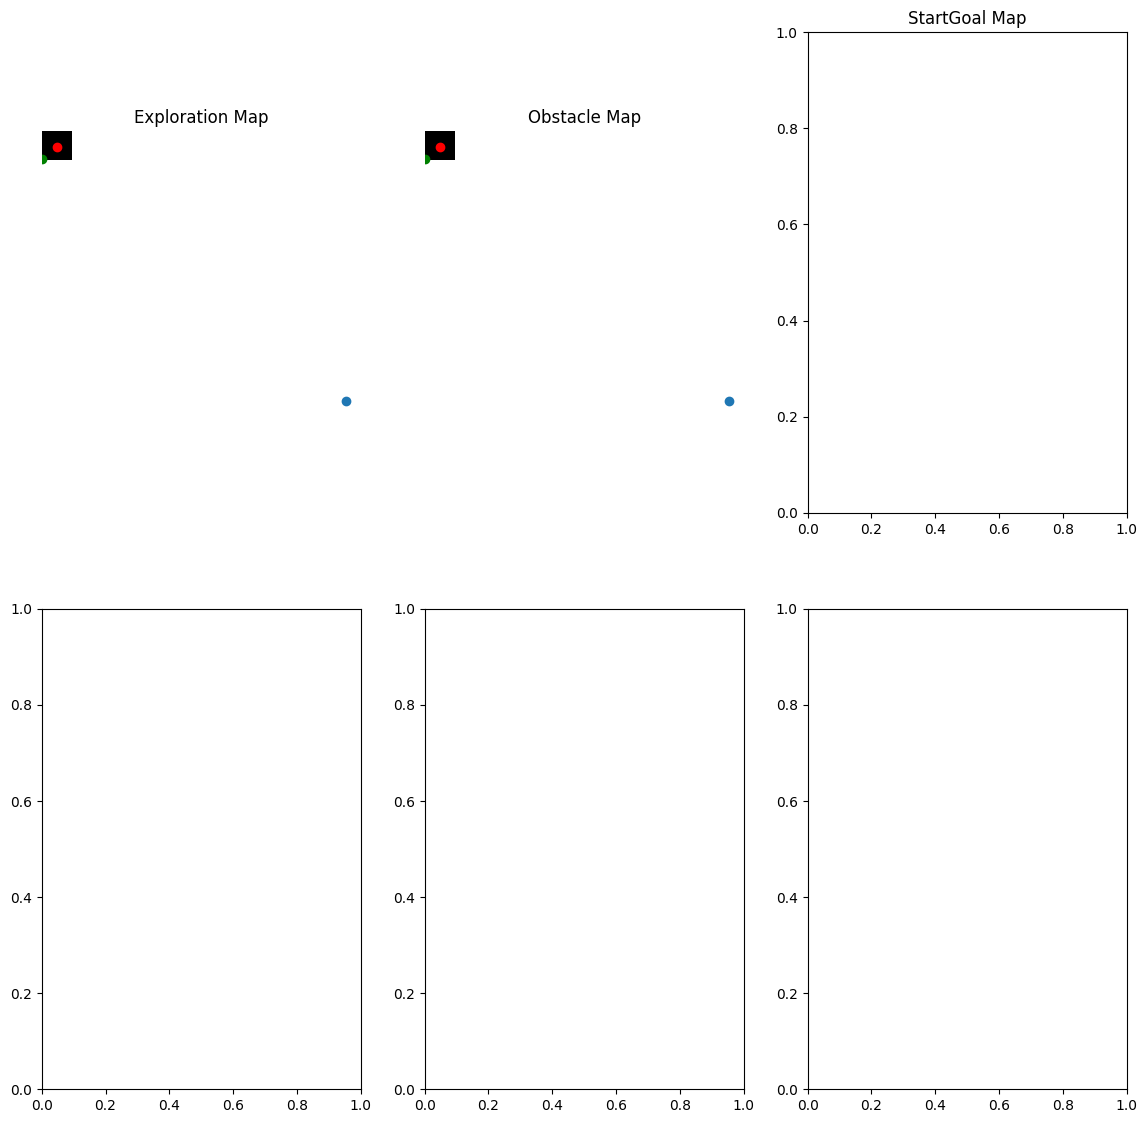

In [14]:
# Plot the patches
env_num = 1
stepNum_ = 100
plt.rcParams['figure.facecolor'] = 'white'
for stepNum in range(stepNum_):
    env_folder = f'tmp/data/exp1/env{env_num}'
    with gzip.open(open(osp.join(env_folder, f'data{stepNum:06d}.p'), 'rb')) as f:
        data = pickle.load(f)

    explored_map = data['explored_map']
    collision_map = data['collision_map']
    gt_map = data['gt_map']
    rgb = data['curr_rgb']
    depth = data['curr_depth']
    path = data['path_to_go']
    goal_pos =  (data['goal'][1], data['goal'][0]) 
    start_pos = (data['curr_loc'][1], data['curr_loc'][0]) 
    gt_path = data['prm_star_path']['path_interpolated']
    gt_goal_pos = geom2pix(gt_path[-1, :], size = (480,480))
    gt_start_pos = geom2pix(gt_path[0, :], size = (480,480))   
    start_pos = data['path_to_go'][0]
    
    true_patch_map = np.zeros_like(explored_map)
    map_size = explored_map.shape
    receptive_field = 32
    
    print(goal_pos)
    for i in range(data['path_to_go'].shape[0]):
        if (geom2pix_mat_pos([start_pos], size = map_size) != geom2pix_mat_pos([data['path_to_go'][i]], size = map_size)):
            next_point_to_go = geom2pix(data['path_to_go'][i] , size=(480,480))
            break
        else:
            next_point_to_go = geom2pix(data['path_to_go'][-1,:] , size=(480,480))
    
    path_pixel_pos = np.array(geom2pix(next_point_to_go,size=(480,480)))# Generate Patch Maps
   
    goal_start_x = max(0, next_point_to_go[0]- receptive_field//2)
    goal_start_y = max(0, next_point_to_go[1]- receptive_field//2)
    goal_end_x = min(map_size[0], next_point_to_go[0]+ receptive_field//2)
    goal_end_y = min(map_size[1], next_point_to_go[1]+ receptive_field//2)
    true_patch_map[goal_start_y:goal_end_y, goal_start_x:goal_end_x] = 1.0

    
    fig, ax = plt.subplots(2, 3, figsize=(14,14), dpi=100)

    ax[0][0].set_title('Exploration Map')
    ax[0][0].imshow(explored_map, cmap='gray')
    ax[0][0].imshow(true_patch_map, cmap='gray', alpha=0.5)
    ax[0][0].plot(path_pixel_pos[0], path_pixel_pos[1], marker='o', linewidth=2)
    ax[0][0].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
    ax[0][0].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
    
    ax[0][0].axis('off')
    
    agent_size = 8
    dx = 0
    dy = 0
    fc = 'Green'
    dx = np.cos(np.deg2rad(data['curr_loc'][2]))
    dy = np.sin(np.deg2rad(data['curr_loc'][2]))
    ax[0][0].arrow(start_pos[0] - 1 * dx, start_pos[1] - 1 * dy, dx * agent_size, dy * agent_size * 1.25,
                head_width=agent_size, head_length=agent_size * 1.25,
                length_includes_head=True, fc=fc, ec=fc, alpha=0.6)
    ax[0][0].invert_yaxis()
    
    
    ax[0][1].set_title('Obstacle Map')
    ax[0][1].imshow(collision_map, cmap='gray')
    ax[0][1].imshow(true_patch_map, cmap='gray', alpha=0.5)
    ax[0][1].plot(path_pixel_pos[0], path_pixel_pos[1], marker='o', linewidth=2)
    ax[0][1].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
    ax[0][1].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
   
    ax[0][1].axis('off')
    ax[0][1].arrow(start_pos[0] - 1 * dx, start_pos[1] - 1 * dy, dx * agent_size, dy * agent_size * 1.25,
                head_width=agent_size, head_length=agent_size * 1.25,
                length_includes_head=True, fc=fc, ec=fc, alpha=0.6)
    ax[0][1].invert_yaxis()
    ax[0][2].set_title('StartGoal Map')
    ax[0][2].imshow(get_start_goal_map(collision_map, start_pos, goal_pos), cmap='gray')
    ax[0][2].plot(path_pixel_pos[0], path_pixel_pos[1], marker='o', linewidth=2)
    ax[0][2].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
    ax[0][2].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
    ax[0][2].invert_yaxis()
    ax[0][2].axis('off')

    rgb = data['curr_rgb']
    im = ax[1][0].imshow(rgb)
    ax[1][0].set_title('RGB')
    ax[1][0].axis('off')

    depth = data['curr_depth']
    im = ax[1][1].imshow(depth, cmap='gray')
    ax[1][1].set_title('Depth')
    ax[1][1].axis('off')

    
    ax[1][2].set_title('Ground Truth Map')
    ax[1][2].imshow(gt_map, cmap='gray')
    gt_path_pixel_pos = np.array([geom2pix(pos,size = (240,240)) for pos in gt_path])
    ax[1][2].plot(gt_path_pixel_pos[:,0], gt_path_pixel_pos[:,1], marker='o', linewidth=2)
    ax[1][2].scatter(gt_goal_pos[0], gt_goal_pos[1], color='r', zorder=3)
    ax[1][2].scatter(gt_start_pos[0], gt_start_pos[1], color='g', zorder=3)
    ax[1][2].invert_yaxis()
    ax[1][2].axis('off')

    #patch_map, pred_map = get_patch(transformer,start_pos, goal_pos, explored_map, collision_map,rgb,depth)
    # ax[1][3].set_title('Region Proposal Patch Map')
    # ax[1][3].imshow(explored_map, cmap='gray')
    # ax[1][3].imshow(patch_map, cmap='gray', alpha=0.5)
    # ax[1][3].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
    # ax[1][3].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
    # ax[1][3].invert_yaxis()
    # ax[1][3].axis('off')
    
    # pred_map = pred_prob[:, 1].cpu().detach().numpy()
    # pred_im = ax[0][3].imshow(pred_map.reshape((12, 12)), cmap="YlOrRd")
    # ax[0][3].set_title('Predictions Probability')
    # ax[0][3].axis('off')
    # ax[0][3].invert_yaxis()
    #cbar = fig.colorbar(pred_im, ax=ax[1], fraction=0.046, pad=0.04)
    
    plt.tight_layout() 
    out_dir = env_folder + '/out/'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    plt.savefig(out_dir+f'data{stepNum:06d}.png')
    plt.close()

In [20]:
import cv2
image_folder = env_folder+'/out/'
video_name = env_folder+'video.avi'

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 15, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()